# Continuous Photobleaching (CP)

### Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.measurements import center_of_mass
from skimage import io, filters
from slb import IntensityCurve

### Determine the directory and the movie

In [2]:
directory = 'data/20210928_BioAvidin_negative'
movie = 'movie-600-fast2.tif'

### Read the movie stack and display average and histogram.

Data shape = (580, 712, 694)
The baseline removed = 269.0


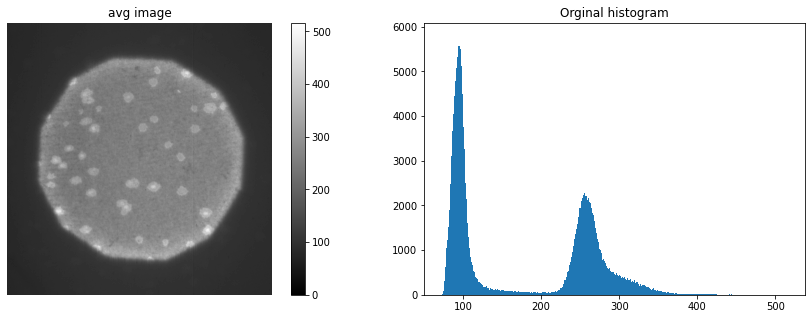

In [3]:
# Read the movie stack
stack = io.imread(f"{directory}/{movie}")[20:, 180:-110, 160:-150].astype(np.float64)

# Print the dimension of the stack
print(f'Data shape = {stack.shape}')

# Remove the baseline
print(f'The baseline removed = {stack.min()}')
stack -= stack.min()

# display the average and it's histogram
plt.figure(figsize=(15,5))

# Average the movie
avg = np.mean(stack, axis=0)

plt.subplot(121)
plt.axis('off')
plt.title('avg image')
plt.imshow(avg, cmap = "gray", vmin=0)
plt.colorbar();

plt.subplot(122)
plt.title('Orginal histogram')
plt.hist(avg.ravel(), bins = 1000);
#plt.xlim(300,800);

### Display the Begining and the End of the stack with better contrast

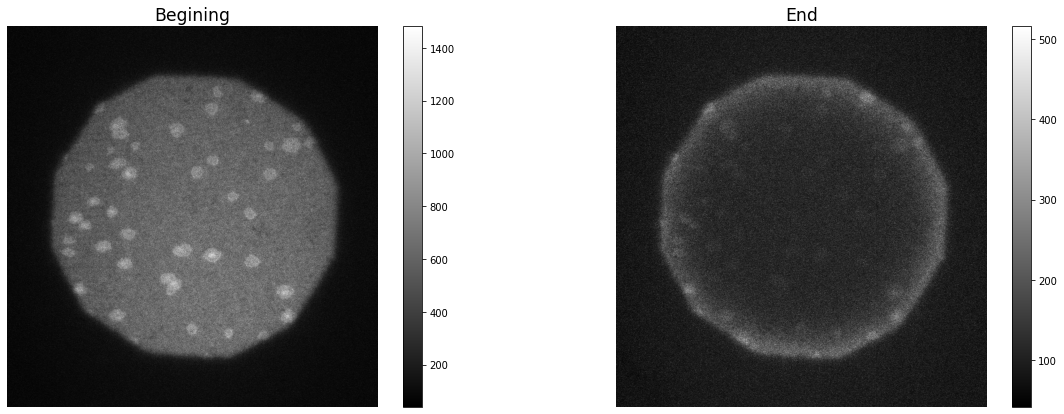

In [4]:
# display the image with better brightness and contrast
plt.figure(figsize=(20,7))

plt.subplot(121)
plt.axis('off')
plt.title('Begining', fontsize='xx-large')
plt.imshow(stack[:5].mean(axis = 0), cmap = "gray")
plt.colorbar();

plt.subplot(122)
plt.axis('off')
plt.title('End', fontsize='xx-large')
plt.imshow(stack[-5:].mean(axis = 0), cmap = "gray")
plt.colorbar();

plt.savefig(f'{directory}/{movie}_Begining_and_END.png')

### Measure the radius and the center on the diaphragm to Determine the ROIs

Radius = 269
Center = [355 350]


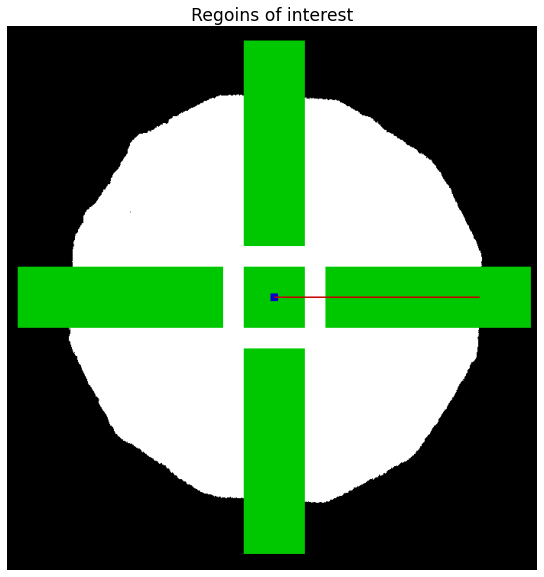

In [5]:
# Getting the threshold of edge filtered image
threshold = filters.threshold_otsu(avg)

# Making a binary mask image with 0 and 1 values
mask = np.multiply(avg > threshold, 1)

# Measure the radius of the diaphragm by treating it as a circle with area = Pi*R^2
radius = int(np.sqrt(np.sum(mask)/(np.pi)))

# Measure the center of mass for the mask and transform it into integer array.
center = np.array(center_of_mass(mask)).astype(int)

print(f'Radius = {radius}\nCenter = {center}')

# Get an RGB copy of the mask
umask = np.zeros([mask.shape[0], mask.shape[1],3]).astype('uint8')
for i in range(mask.shape[0]):
    for j in range(mask.shape[1]):
        umask[i,j] = mask[i,j] * np.array([255, 255, 255])

# Draw the regions to be measured
umask[center[0]-40:center[0]+40, center[1]-40:center[1]+40] = [0,200,0]                         # Rectangle center
umask[center[0]-40:center[0]+40, center[1]+int(radius/4):center[1]+int(radius*5/4)] = [0,200,0] # Rectangle right
umask[center[0]-40:center[0]+40, center[1]-int(radius*5/4):center[1]-int(radius/4)] = [0,200,0] # Rectangle left
umask[center[0]-int(radius*5/4):center[0]-int(radius/4), center[1]-40:center[1]+40] = [0,200,0] # Rectangle up
umask[center[0]+int(radius/4):center[0]+int(radius*5/4), center[1]-40:center[1]+40] = [0,200,0] # Rectangle down


# Draw the radius and the center on the mask
umask[center[0]-5:center[0]+5, center[1]-5:center[1]+5] = [0,0,200] # Center
umask[center[0]-1:center[0]+1, center[1]:center[1]+radius] = [200,0,0] # Radius

# display the image with better brightness and contrast
plt.figure(figsize=(10,10))
plt.axis('off')
plt.title('Regoins of interest', fontsize='xx-large')
plt.imshow(umask);
plt.savefig(f'{directory}/{movie}_Regions_of_interest.png')

### Fit the Intensity curves on the Intensity equations to get the diffusion constant:
Intensity equation of time

$I(t) = I_0 e^{(-Bt)} + I_{b}$

Intensity equation of space

$I(x) = I_0 e^{-x \sqrt{B/D}} + I_{b}$

where $I_0 , I_{b}, B, D$ are fitting parameters.

$I_0$: Initial intensity

$I_{b}$: Background intensity

$B$: Bleaching rate of the fluorophores

$D$: Diffusion constant

Intensity equation of time:
Io = 550.123
Ib = 94.365
B = 0.056

Intensity equation of space:
Io = 101.357
Ib = 115.808
D = 0.882


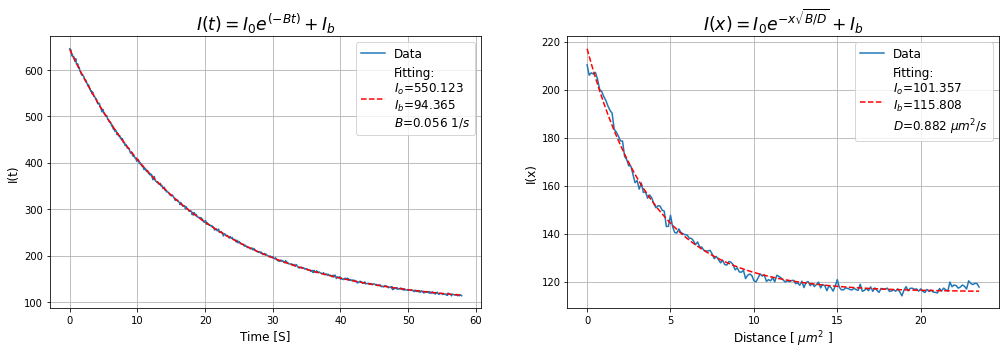

In [6]:
# Take the average of the center to get I(t)
It = np.mean(stack[:,center[0]-40:center[0]+40, center[1]-40:center[1]+40], axis=(1,2))
t  = np.arange(It.shape[0]) * 0.1

# Take the means to get the curves
rectangle_right  = np.mean(stack[-10:,center[0]-40:center[0]+40, center[1]+int(radius/4):center[1]+int(radius*5/4)],
                           axis=(0,1))
rectangle_left   = np.mean(stack[-10:,center[0]-40:center[0]+40, center[1]-int(radius*5/4):center[1]-int(radius/4)],
                           axis=(0,1))
rectangle_up     = np.mean(stack[-10:,center[0]-int(radius*5/4):center[0]-int(radius/4), center[1]-40:center[1]+40],
                           axis=(0,2))
rectangle_down   = np.mean(stack[-10:,center[0]+int(radius/4):center[0]+int(radius*5/4), center[1]-40:center[1]+40],
                           axis=(0,2))

# Reverse the right and the down rectangle
rectangle_right = rectangle_right[::-1]
rectangle_down  = rectangle_down[::-1]

# Take the average of the rectangles to get I(x)
Ix = np.mean([rectangle_right, rectangle_left, rectangle_up, rectangle_down], axis=0)[80:]
x  = np.arange(Ix.shape[0]) * 0.125


# Fit the curves and
It_curve = IntensityCurve(t, x, It, Ix)
B, Io_t, Ib_t, D, Io_x, Ib_x = It_curve.curve_fitting()

# Print the parameters
print(f'Intensity equation of time:\nIo = {Io_t:.3f}\nIb = {Ib_t:.3f}\nB = {B:.3f}\n')
print(f'Intensity equation of space:\nIo = {Io_x:.3f}\nIb = {Ib_x:.3f}\nD = {D:.3f}')

# Display the results
plt.figure(figsize=(17,5))

# Intensity time curve
plt.subplot(121)
plt.plot(t, It, label='Data')
plt.plot(t, Io_t * np.exp(-B*t) + Ib_t, "r--",
         label =f'Fitting:\n$I_o$={Io_t:.3f}\n$I_b$={Ib_t:.3f}\n$B$={B:.3f} $1/s$')
plt.title('$I(t) = I_0 e^{(-Bt)} + I_{b}$', fontsize='xx-large')
plt.xlabel('Time [S]', fontsize='large')
plt.ylabel('I(t)', fontsize='large')
plt.grid()
plt.legend(fontsize='large')

# Intensity space curve
plt.subplot(122)
plt.plot(x, Ix, label='Data')
plt.plot(x, Io_x * np.exp(-x*np.sqrt(B/D)) + Ib_x, "r--",
         label =f'Fitting:\n$I_o$={Io_x:.3f}\n$I_b$={Ib_x:.3f}\n$D$={D:.3f} $\mu m^2/s$')
plt.title('$I(x) = I_0 e^{-x \sqrt{B/D}} + I_{b}$', fontsize='xx-large')
plt.xlabel('Distance [ $\mu m^2$ ]', fontsize='large')
plt.ylabel('I(x)', fontsize='large')
plt.grid()
plt.legend(fontsize='large');

plt.savefig(f'{directory}/{movie}_D={D:.3f}.pdf')
plt.savefig(f'{directory}/{movie}_D={D:.3f}.png')

### Display the detailed curves

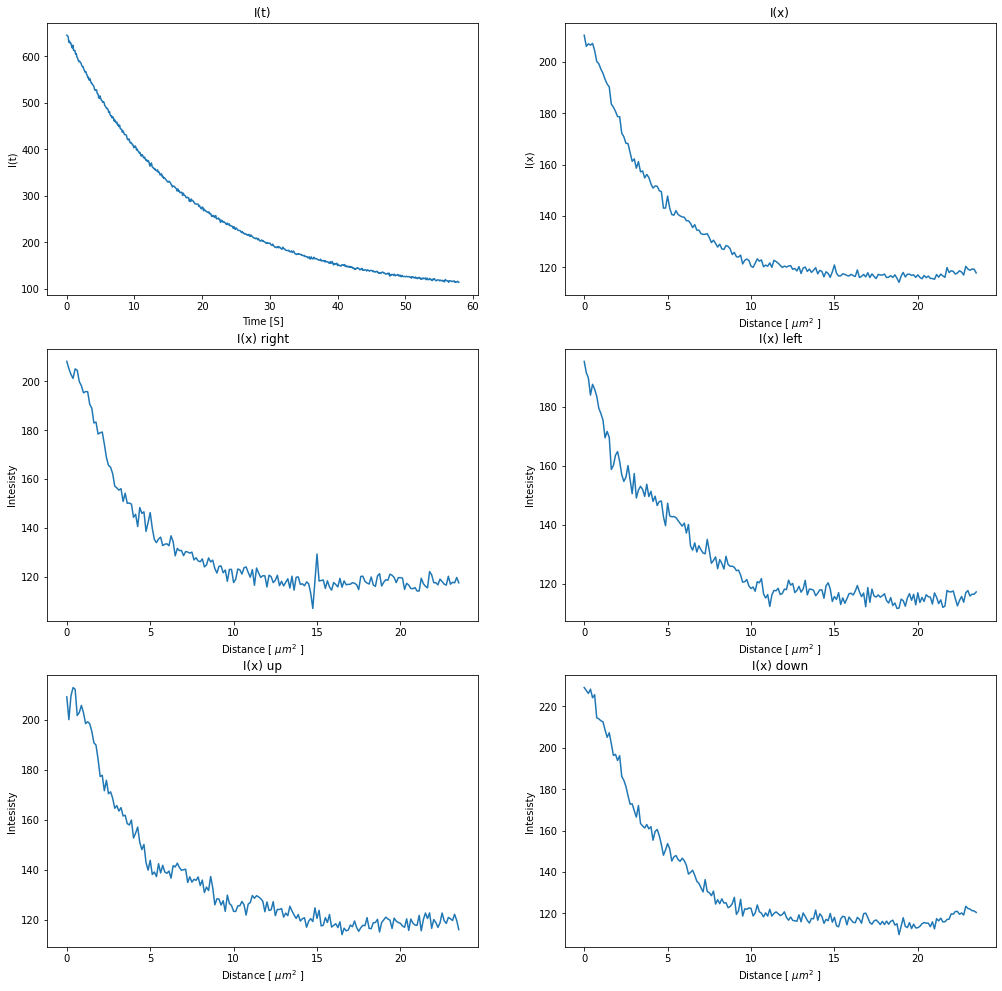

In [7]:
# display the image with better brightness and contrast
plt.figure(figsize=(17,17))

plt.subplot(321)
plt.plot(t, It)
plt.title('I(t)')
plt.xlabel('Time [S]')
plt.ylabel('I(t)')

plt.subplot(322)
plt.plot(x, Ix)
plt.title('I(x)');
plt.xlabel('Distance [ $\mu m^2$ ]')
plt.ylabel('I(x)');

plt.subplot(323)
plt.plot(np.arange(rectangle_right[80:].shape[0]) * 0.125, rectangle_right[80:])
plt.title('I(x) right')
plt.xlabel('Distance [ $\mu m^2$ ]')
plt.ylabel('Intesisty')

plt.subplot(324)
plt.plot(np.arange(rectangle_left[80:].shape[0]) * 0.125, rectangle_left[80:])
plt.title('I(x) left')
plt.xlabel('Distance [ $\mu m^2$ ]')
plt.ylabel('Intesisty')

plt.subplot(325)
plt.plot(np.arange(rectangle_up[80:].shape[0]) * 0.125, rectangle_up[80:])
plt.title('I(x) up')
plt.xlabel('Distance [ $\mu m^2$ ]')
plt.ylabel('Intesisty')

plt.subplot(326)
plt.plot(np.arange(rectangle_down[80:].shape[0]) * 0.125, rectangle_down[80:])
plt.title('I(x) down')
plt.xlabel('Distance [ $\mu m^2$ ]')
plt.ylabel('Intesisty');

plt.savefig(f'{directory}/{movie}_Regoins_curves.png')